# Project - Third Requirement

### Include packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import norm

## Preliminar phase

### Environment

Let's define some types of non-stationary environments...

In [2]:
class Environment:
    def __init__(self):
        pass
    def round(self, a_t):
        pass

With sinusoidally-varying "true value".

In [3]:
# Here we model the probability of buying around the mean valuation as a gaussian distribution...
# ... but its mean keeps changing sinusoidally over time, with a fixed amplitude and period.
class PricingEnvironmentSingleProductSinusoidalMean(Environment):
    def __init__(self, cost, initial_mean_valuation, std_valuation, buyers_per_round, total_rounds, amplitude, period):
        self.cost = cost
        self.initial_mean_valuation = initial_mean_valuation
        self.std_valuation = std_valuation
        self.buyers_per_round = buyers_per_round
        self.total_rounds = total_rounds            # Needed to define the full cycle
        self.current_round = 0                      # To track time
        self.amplitude = amplitude                  # How much the mean valuation swings up and down
        self.period = period                        # How many rounds it takes to complete one full cycle

    def round(self, p_t):
        current_mean_valuation = self.initial_mean_valuation + self.amplitude * np.sin(2 * np.pi * self.current_round / self.period)

        # Probability of a single customer buying at price p_t
        # loc=current_mean_valuation means the center of the valuation distribution shifts
        prob_buy = 1 - norm.cdf(p_t, loc=current_mean_valuation, scale=self.std_valuation)

        # Ensure probability is within valid range [0, 1] due to extreme values in sine wave
        prob_buy = np.clip(prob_buy, 0, 1)

        # Number of sales is drawn from a binomial distribution
        num_of_sales = np.random.binomial(n=self.buyers_per_round, p=prob_buy)

        reward = (p_t - self.cost) * num_of_sales
        
        self.current_round += 1 # Advance the environment's internal clock
        return num_of_sales, reward

With steadily-increasing "true value".

In [4]:
class PricingEnvironmentSingleProductDriftingMean(Environment):
    def __init__(self, cost, initial_mean_valuation, std_valuation, buyers_per_round, drift_rate):
        self.cost = cost
        self.initial_mean_valuation = initial_mean_valuation
        self.std_valuation = std_valuation
        self.buyers_per_round = buyers_per_round
        self.drift_rate = drift_rate            # How much the mean valuation changes per round
        self.current_round = 0                  # To track time

    def round(self, p_t):
        current_mean_valuation = self.initial_mean_valuation + (self.current_round * self.drift_rate)

        # Probability of a single customer buying at price p_t
        # loc=current_mean_valuation means the center of the valuation distribution shifts
        prob_buy = 1 - norm.cdf(p_t, loc=current_mean_valuation, scale=self.std_valuation)

        # Ensure probability is within valid range [0, 1] (important if drift leads to very high/low valuations)
        prob_buy = np.clip(prob_buy, 0, 1)

        # Number of sales is drawn from a binomial distribution
        num_of_sales = np.random.binomial(n=self.buyers_per_round, p=prob_buy)

        reward = (p_t - self.cost) * num_of_sales
        
        self.current_round += 1 # Advance the environment's internal clock
        return num_of_sales, reward

### Now define the setting...

In [5]:
# --- Global Settings ---

N = 1                     # Number of products (unused in this version)
T = 20000                 # Time horizon (number of rounds)
n_trials = 5              # Number of independent trials for averaging

# --- Pricing Grid and Product Info ---

cost = 2.00                       # Unit production cost
initial_value = 5.00              # Initial mean valuation of the product
std_valuation = 1.0               # Standard deviation of customer valuations

min_p = 0.0
max_p = int(initial_value * 2)
K = 10                                  # Number of prices to test
P = np.linspace(min_p, max_p, K)        # Prices to test        

assert cost < initial_value , "Cost must be less than value"

# --- Market and Inventory Parameters ---

B = 120000 * N                          # Total inventory available (seller capacity)
rho = B/T

amplitude = 2.0
period = 1000

drift_rate = initial_value / T

# --- Derived Buyer Generation per Round ---

buyers_per_round = 50                   # Number of buyers per round per product
assert buyers_per_round >= 1, "Must have at least one buyer per round"

# --- Other Parameters ---

zoom_end_mini = 200         # Show only up to 200 rounds in mini plots
zoom_end = 2 * period       # Show only up to 2 periods
zoom_end_5 = 5000           # Start zooming 5k rounds
s = 30                      # random seed

# --- Formatter for Millions in the plots---
def millions_formatter(x, pos):
    return f'{x / 1e6:.1f}M'

Plus an auxiliary function...

In [6]:
def compute_expected_profit_bound(prices, cost, buyers_per_round, initial_value, std_valuation):
    max_expected_profit = 0
    for p in prices:
        prob_buy = 1 - norm.cdf(p, loc=initial_value, scale=std_valuation)
        expected_sales = prob_buy * buyers_per_round
        profit = expected_sales * (p - cost)
        if profit > max_expected_profit:
            max_expected_profit = profit
    return max_expected_profit

print("Starting upperbound for agent's lambda: ", float(compute_expected_profit_bound(P, cost, buyers_per_round, initial_value, std_valuation)) / rho)


Starting upperbound for agent's lambda:  14.478090799456124


### Design our agent

Since the environment is not stochastic, we choose an algorithm for adversarial environments to be used as primal regret minimizer of a primal-dual strategy. In particular, Hedge would require full feedback, so we adopt EXP3.P, while using gradient descent to minimize the Lagrange multiplier. The value of the learning rate has been tuned by manually running the experiment for 0.1, 0.01 and 0.001.

Pay attention to the lambda upperbound.

In [7]:
# ------------ Primal ------------- #

class EXP3P:
    def __init__(self, K, gamma, eta, max_reward_scale):
        self.K = K
        self.gamma = gamma                          # Exploration rate (how much we don't trust our weights)
        self.eta = eta                              # Learning rate
        self.weights = np.ones(K)
        self.probabilities = np.zeros(K)
        self.max_reward_scale = max_reward_scale    # Safe upper bound on absolute reward

    def choose_action(self):
        # Compute distribution out of weights and choose 
        self.probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + (self.gamma / self.K)   # High gamma => uniform
        self.probabilities /= np.sum(self.probabilities)  # Just in case
        return np.random.choice(self.K, p=self.probabilities)

    def update(self, chosen_action_idx, observed_reward):
        # Compute loss with normalized reward in [0,1]  
        loss_t = (1 - observed_reward / self.max_reward_scale) / 2
        estimated_loss = loss_t / self.probabilities[chosen_action_idx]
        # Update weights
        self.weights[chosen_action_idx] *= np.exp(-self.eta * estimated_loss)
        # In case weights are getting too large or too small, re-normalize
        if np.sum(self.weights) < 1e-100 or np.sum(self.weights) > 1e100:
            self.weights /= np.max(self.weights)

# ------------- Primal-Dual ------------ #

class PrimalDualPricingAgent:
    def __init__(self, prices, B, T, cost, buyers_per_round, initial_lambda=0, learning_rate_lambda=0.01, exp3p_gamma=0.001):
        self.prices = prices
        self.K = len(prices)
        self.B = B
        self.T = T
        self.cost = cost
        self.buyers_per_round = buyers_per_round
        self.rho = B / T if T > 0 else 1e-8
        self.lambda_t = initial_lambda
        self.eta_lambda = learning_rate_lambda
        max_reward_scale = ( max(self.prices) - self.cost ) * buyers_per_round 
        self.num_sales_t = 0 

        self.primal_regret_minimizer = EXP3P(K=self.K, gamma=exp3p_gamma, eta=np.sqrt(np.log(self.K) / (self.K * self.T)), max_reward_scale=max_reward_scale)

        self.current_round = 0
        self.remaining_budget = B
        self.history_sales = []
        self.history_rewards = []
        self.history_effective_rewards = []
        self.history_lambda = [self.lambda_t]
        self.history_chosen_prices = []

    def choose_price(self):
        price_idx = self.primal_regret_minimizer.choose_action()
        price = self.prices[price_idx]
        self.history_chosen_prices.append(price)
        return price, price_idx

    def update(self, price_idx, num_sales, reward):
        # Compute effective reward
        price = self.prices[price_idx]
        effective_reward = ( price - self.cost ) * num_sales - self.lambda_t * (num_sales - self.rho)

        # Update primal and history
        self.primal_regret_minimizer.update(price_idx, effective_reward)
        self.history_effective_rewards.append(effective_reward)
        self.history_sales.append(num_sales)
        self.history_rewards.append(reward)

        # New round update
        self.num_sales_t = num_sales
        self.remaining_budget -= num_sales
        self.current_round += 1
        self.rho = self.remaining_budget / (self.T - self.current_round) if (self.T - self.current_round) > 0 else 0

        # Update lambda
        diff = self.rho - num_sales
        self.lambda_t += -self.eta_lambda * diff
        upper_bound_lambda = compute_expected_profit_bound(self.prices, self.cost, self.buyers_per_round, initial_value, std_valuation) / max(self.rho, 1e-6)
        self.lambda_t = np.clip(self.lambda_t, 0, upper_bound_lambda)
        self.history_lambda.append(self.lambda_t)


## First experiment

### Run in sinusoidal environment

In [8]:
# --- Simulation ---
all_rewards = []      # Shape: (n_trials, T)
all_lambdas = []      # Shape: (n_trials, <=T+1)
all_rho = []          # Shape: (n_trials, <=T)
all_sold_pieces = []  # Shape: (n_trials, <=T)
for seed in range(n_trials):
    np.random.seed(seed)

    # Setup environment and agent
    env = PricingEnvironmentSingleProductSinusoidalMean(cost=cost, initial_mean_valuation=initial_value, std_valuation=std_valuation, buyers_per_round=buyers_per_round, total_rounds=T, amplitude=amplitude, period=period)
    agent = PrimalDualPricingAgent(prices=P, B=B, T=T, cost=cost, buyers_per_round=buyers_per_round, initial_lambda=initial_value)

    # Time horizon
    rewards_this_trial = []
    rho_values = []
    sold_pieces_values = []
    for t in range(T):

        # Terminate early: fill remaining rounds with 0
        if agent.remaining_budget < 1:
            rewards_this_trial.extend([0] * (T - t))
            break

        # Choose price and get sales and reward
        price, idx = agent.choose_price()
        sales, reward = env.round(price)
        agent.update(idx, sales, reward)
        rewards_this_trial.append(reward)
        rho_values.append(agent.rho)
        sold_pieces_values.append(agent.num_sales_t)

    # Store results for this trial
    all_rewards.append(np.cumsum(rewards_this_trial))
    all_lambdas.append(agent.history_lambda)
    all_rho.append(rho_values)
    all_sold_pieces.append(sold_pieces_values)

# --- Analysis and Plotting ---

all_rewards = np.array(all_rewards)                            # Shape: (n_trials, T)
mean_cum_util = np.mean(all_rewards, axis=0)
std_cum_util = np.std(all_rewards, axis=0)

# Compute mean and std, but only up to the minimum length of all trials (where all have data)
min_len = min(len(l) for l in all_lambdas)
all_lambdas_trimmed = np.array([l[:min_len] for l in all_lambdas])

mean_lambda = np.mean(all_lambdas_trimmed, axis=0)
std_lambda = np.std(all_lambdas_trimmed, axis=0)

print(f">>> Cumulative utility after {T} rounds: {mean_cum_util[-1]:.2f} ± {std_cum_util[-1]:.2f}")

>>> Cumulative utility after 20000 rounds: 312370.40 ± 16181.43


### Plot Regret

Compute clairvoyants.

In [9]:
# ---------------------------------------------------------------------------------------
# Clairvoyant 1 and 2: Budget-Aware Fixed-Best and Overpower Clairvoyant
# ---------------------------------------------------------------------------------------

# Generate sinusoidal mean valuations for each round
mean_valuations = initial_value + amplitude * np.sin(2 * np.pi * np.arange(T) / period)

# Initialize clairvoyant counters
remaining_budget_clairvoyant = B
clairvoyant_cum_rewards = []
cum_reward = 0
clairvoyant_nobudget_cum_rewards = []
cum_reward_nobudget = 0

# Initialize stats for each arm for budget-aware clairvoyant
arm_stats = { p: { "reward": 0.0, "budget_spent": 0.0, "cum_rewards": [] } for p in P if p > cost }

for t in range(T):
    mu_t = mean_valuations[t]  # Mean valuation at round t

    # ----------------------------- Overpower clairvoyant -----------------------------
    best_reward_this_round = -np.inf
    # For each price (arm), compute expected reward at this round
    max_expected_profit = 0
    cum_reward_nobudget += compute_expected_profit_bound(P, cost, buyers_per_round, mu_t, std_valuation)
    clairvoyant_nobudget_cum_rewards.append(cum_reward_nobudget)

    # ----------------------------- Budget-aware clairvoyant -----------------------------
    for p in arm_stats:
        stats = arm_stats[p]
        # If budget is exhausted, just append final reward again
        if stats["budget_spent"] >= B:
            # No budget left, just append the last reward
            stats["cum_rewards"].append(stats["reward"])
            continue
        # Compute how much p gets at this round
        prob_buy = 1 - norm.cdf(p, loc=mu_t, scale=std_valuation)
        expected_sales = prob_buy * buyers_per_round
        expected_cost = expected_sales * p
        max_sales_affordable = (B - stats["budget_spent"]) / p
        actual_sales = min(expected_sales, max_sales_affordable)
        actual_cost = actual_sales * p
        actual_reward = actual_sales * (p - cost)
        # Update stats
        stats["budget_spent"] += actual_cost
        stats["reward"] += actual_reward
        stats["cum_rewards"].append(stats["reward"])

# ----------------------------- 1. Budget-aware clairvoyant summary -----------------------------
print(">>> Budget-aware Clairvoyant Summary: Reward and Budget Used per Price (Arm) ---")
print(f"{'Price':>8} | {'Total Reward':>20} | {'Budget Used':>20}")
print("-" * 55)
for p in sorted(arm_stats):
    r = arm_stats[p]["reward"]
    b = arm_stats[p]["budget_spent"]
    print(f"{p:8.2f} | {r:20,.2f} | {b:20,.2f}")
best_arm = max(arm_stats, key=lambda p: arm_stats[p]["reward"])
print(f"Best arm: price = {best_arm}, reward = {arm_stats[best_arm]['reward']:.2f}")
print()

# ----------------------------- 2. Overpower clairvoyant summary -----------------------------
print(f">>> Overpower No-budget Clairvoyant")
print(f"    Total reward = {cum_reward_nobudget:.2f}\n")

# ---------------------------------------------------------------------------------------
# Clairvoyant 3: Budget-Aware Static-Mean Fixed-Price Clairvoyant
# ---------------------------------------------------------------------------------------

# Compute expected demand and profit for static clairvoyant
def expected_demand(p):
    return np.sum(1 - norm.cdf(p, loc=np.full(buyers_per_round, initial_value), scale=1.0))

expected_demand_vector = np.array([expected_demand(p) for p in P])
expected_profit_vector = (P - cost) * expected_demand_vector

best_expected_index = np.argmax(expected_profit_vector)
best_expected_price = P[best_expected_index]
best_expected_profit = expected_profit_vector[best_expected_index]
best_expected_demand = expected_demand_vector[best_expected_index]

expected_cost_per_round = best_expected_demand * cost

# Initialize cumulative reward with budget check
static_clairvoyant_cum_rewards = np.zeros(T)
cumulative_cost = 0
for t in range(T):
    if cumulative_cost + expected_cost_per_round <= B:
        static_clairvoyant_cum_rewards[t] = best_expected_profit
        cumulative_cost += expected_cost_per_round
    else:
        # Stop collecting reward after budget is exceeded
        static_clairvoyant_cum_rewards[t] = 0.0

# Convert per-round to cumulative rewards
static_clairvoyant_cum_rewards = np.cumsum(static_clairvoyant_cum_rewards)

print(f">>> Static Assumption Clairvoyant: best price = {best_expected_price:.2f}")
print(f"    Expected profit assuming static demand = {best_expected_profit:.2f}")
print(f"    Static Clairvoyant: total reward = {static_clairvoyant_cum_rewards[-1]:.2f}")

>>> Budget-aware Clairvoyant Summary: Reward and Budget Used per Price (Arm) ---
   Price |         Total Reward |          Budget Used
-------------------------------------------------------
    2.22 |            12,000.00 |           120,000.00
    3.33 |            48,000.00 |           120,000.00
    4.44 |            66,000.00 |           120,000.00
    5.56 |            76,800.00 |           120,000.00
    6.67 |            84,000.00 |           120,000.00
    7.78 |            89,142.86 |           120,000.00
    8.89 |            36,992.52 |            47,732.28
   10.00 |             1,664.83 |             2,081.04
Best arm: price = 7.777777777777779, reward = 89142.86

>>> Overpower No-budget Clairvoyant
    Total reward = 1797877.98

>>> Static Assumption Clairvoyant: best price = 4.44
    Expected profit assuming static demand = 86.87
    Static Clairvoyant: total reward = 146634.10


And plot the regret.

Final Regret (Budget-Aware Clairvoyant): -223,227.54
Final Regret (No-Budget Clairvoyant): 1,485,507.58
Final Regret (Static Clairvoyant): -165,736.30


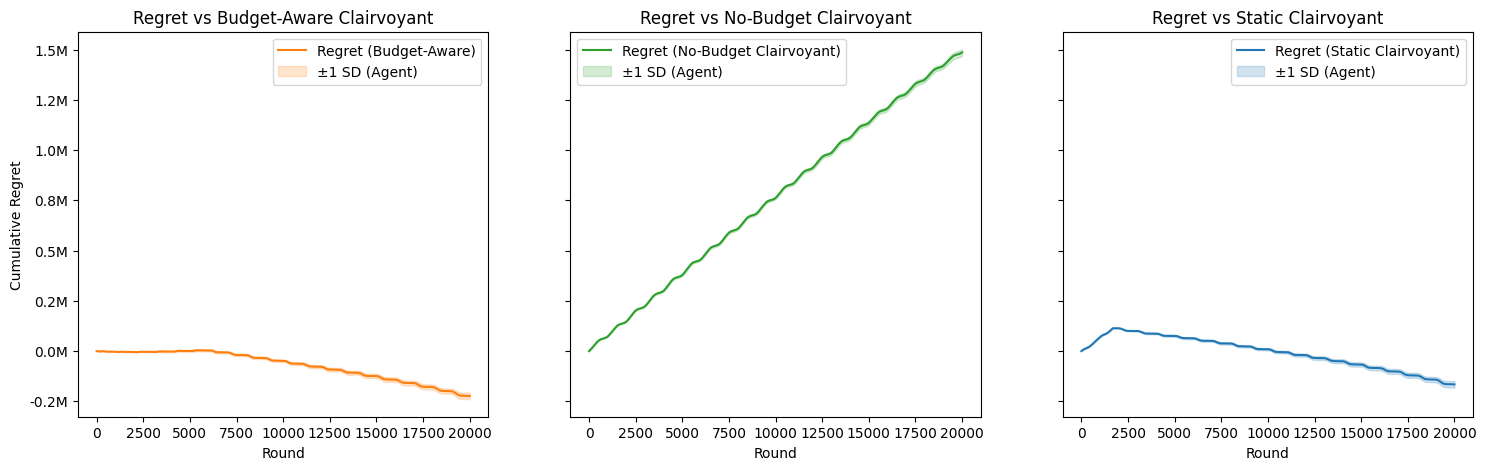

In [10]:
# --- Compute regrets ---
regret_budget_aware = np.array(arm_stats[best_arm]["cum_rewards"]) - mean_cum_util
regret_nobudget = np.array(clairvoyant_nobudget_cum_rewards) - mean_cum_util
regret_static = static_clairvoyant_cum_rewards - mean_cum_util

print(f"Final Regret (Budget-Aware Clairvoyant): {regret_budget_aware[-1]:,.2f}")
print(f"Final Regret (No-Budget Clairvoyant): {regret_nobudget[-1]:,.2f}")
print(f"Final Regret (Static Clairvoyant): {regret_static[-1]:,.2f}")

# --- Plot grid ---
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# --- Budget-Aware Clairvoyant ---
axs[0].plot(regret_budget_aware, color="tab:orange", label="Regret (Budget-Aware)")
axs[0].fill_between(np.arange(T), regret_budget_aware - std_cum_util, regret_budget_aware + std_cum_util, color="tab:orange", alpha=0.2, label="±1 SD (Agent)")
axs[0].set_title("Regret vs Budget-Aware Clairvoyant")
axs[0].set_xlabel("Round")
axs[0].set_ylabel("Cumulative Regret")
axs[0].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions_formatter))
axs[0].legend()

# --- No-Budget Clairvoyant ---
axs[1].plot(regret_nobudget, color="tab:green", label="Regret (No-Budget Clairvoyant)")
axs[1].fill_between(np.arange(T), regret_nobudget - std_cum_util, regret_nobudget + std_cum_util, color="tab:green", alpha=0.2, label="±1 SD (Agent)")
axs[1].set_title("Regret vs No-Budget Clairvoyant")
axs[1].set_xlabel("Round")
axs[1].legend()

# --- Static Clairvoyant ---
axs[2].plot(regret_static, color="tab:blue", label="Regret (Static Clairvoyant)")
axs[2].fill_between(np.arange(T), regret_static - std_cum_util, regret_static + std_cum_util, color="tab:blue", alpha=0.2, label="±1 SD (Agent)")
axs[2].set_title("Regret vs Static Clairvoyant")
axs[2].set_xlabel("Round")
_ = axs[2].legend()

### More analysis

Plot λ over time

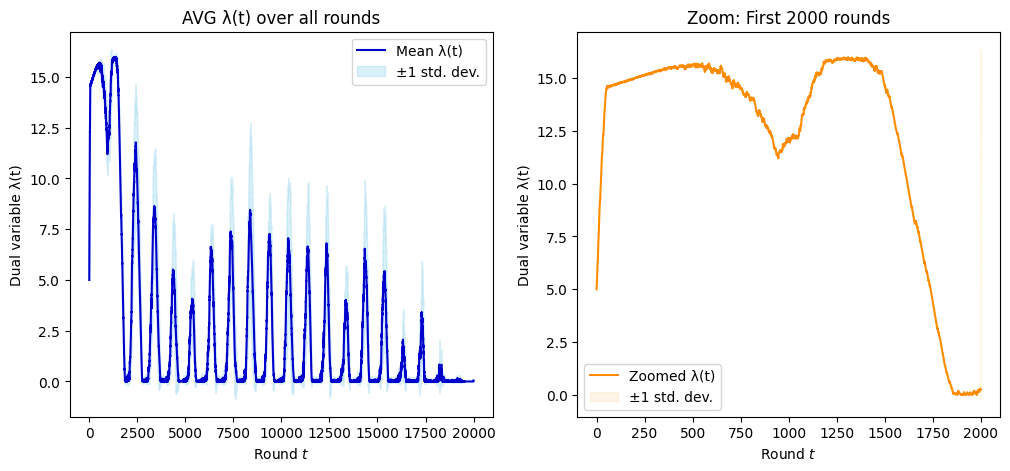

In [11]:
# How important was our constraint during the rounds?
plt.figure(figsize=(12, 5))

# --- Plot of λ(t) ---
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(mean_lambda)), mean_lambda, label='Mean λ(t)', color='mediumblue')
plt.fill_between(np.arange(len(mean_lambda)), mean_lambda - std_lambda, mean_lambda + std_lambda, color='skyblue', alpha=0.3, label='±1 std. dev.')
plt.xlabel('Round $t$')
plt.ylabel('Dual variable λ(t)')
plt.title('AVG λ(t) over all rounds')
plt.legend()

# --- Zoom on first 2000 rounds ---
plt.subplot(1, 2, 2)
plt.plot(np.arange(len(mean_lambda))[:zoom_end], mean_lambda[:zoom_end], label='Zoomed λ(t)', color='darkorange')
plt.fill_between(np.arange(len(mean_lambda))[zoom_end], mean_lambda[:zoom_end] - std_lambda[:zoom_end], mean_lambda[:zoom_end] + std_lambda[:zoom_end], color='navajowhite', alpha=0.3, label='±1 std. dev.')
plt.xlabel('Round $t$')
plt.ylabel('Dual variable λ(t)')
plt.title(f'Zoom: First {zoom_end} rounds')
_ = plt.legend()

Plotting ρ (rho) vs Cost per round

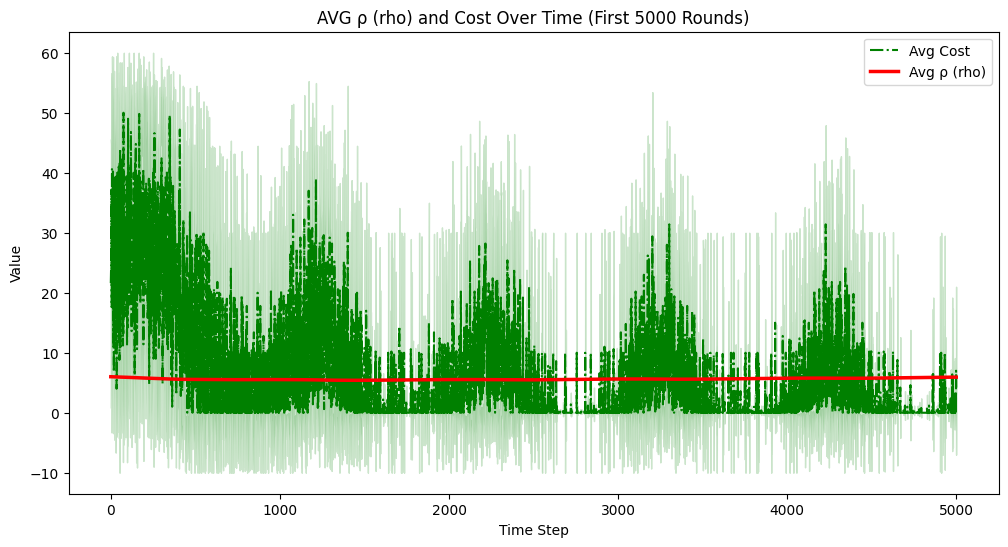

In [12]:
max_len = max(len(r) for r in all_rho)  # max length among trials
all_rho_padded = [r + [np.nan]*(max_len - len(r)) for r in all_rho]
all_sold_pieces_padded = [s + [np.nan]*(max_len - len(s)) for s in all_sold_pieces]

all_rho_array = np.array(all_rho_padded)           
all_sold_pieces_array = np.array(all_sold_pieces_padded)

mean_rho = np.nanmean(all_rho_array, axis=0)
std_rho = np.nanstd(all_rho_array, axis=0)
mean_sold_pieces = np.nanmean(all_sold_pieces_array, axis=0)
std_sold_pieces = np.nanstd(all_sold_pieces_array, axis=0)

time_steps = np.arange(max_len)  # use max_len here!

plt.figure(figsize=(12, 6))

plt.plot(time_steps[:zoom_end_5], mean_sold_pieces[:zoom_end_5], label='Avg Cost', color='green', linestyle='-.')
plt.fill_between(time_steps[:zoom_end_5], mean_sold_pieces[:zoom_end_5] - std_sold_pieces[:zoom_end_5], mean_sold_pieces[:zoom_end_5] + std_sold_pieces[:zoom_end_5], color='green', alpha=0.2)

plt.plot(time_steps[:zoom_end_5], mean_rho[:zoom_end_5], label='Avg ρ (rho)', color='red', linewidth=2.5, zorder=3)
plt.fill_between(time_steps[:zoom_end_5], mean_rho[:zoom_end_5] - std_rho[:zoom_end_5], mean_rho[:zoom_end_5] + std_rho[:zoom_end_5], color='red', alpha=0.2)

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title(f'AVG ρ (rho) and Cost Over Time (First {zoom_end_5} Rounds)')
_ = plt.legend()

## Second experiment

### Now with drifting increasing environment

In [13]:
# --- Simulation ---
all_rewards = []      # Shape: (n_trials, T)
all_lambdas = []      # Shape: (n_trials, <=T+1)
all_rho = []          # Shape: (n_trials, <=T)
all_sold_pieces = []  # Shape: (n_trials, <=T)

for seed in range(n_trials):
    np.random.seed(seed)
    
    # Set up environment and agent
    env = PricingEnvironmentSingleProductDriftingMean(cost=cost, initial_mean_valuation=initial_value, std_valuation=std_valuation, buyers_per_round=buyers_per_round, drift_rate=drift_rate)
    agent = PrimalDualPricingAgent(prices=P, B=B, T=T, cost=cost, buyers_per_round=buyers_per_round, initial_lambda=initial_value)
    
    # Time horizon
    rewards_this_trial = []
    rho_values = []
    sold_pieces_values = []
    for t in range(T):

        # Terminate early: fill remaining rounds with 0
        if agent.remaining_budget < 1:
            rewards_this_trial.extend([0] * (T - t))
            break

        # Choose price and get sales and reward
        price, idx = agent.choose_price()
        sales, reward = env.round(price)
        agent.update(idx, sales, reward)
        rewards_this_trial.append(reward)
        rho_values.append(agent.rho)
        sold_pieces_values.append(agent.num_sales_t)

    # Store results for this trial
    all_rewards.append(np.cumsum(rewards_this_trial))
    all_lambdas.append(agent.history_lambda)
    all_rho.append(rho_values)
    all_sold_pieces.append(sold_pieces_values)

# --- Analysis and Plotting ---

all_rewards = np.array(all_rewards)                            # Shape: (n_trials, T)
mean_cum_util = np.mean(all_rewards, axis=0)
std_cum_util = np.std(all_rewards, axis=0)

# Compute mean and std, but only up to the minimum length of all trials (where all have data)
min_len = min(len(l) for l in all_lambdas)
all_lambdas_trimmed = np.array([l[:min_len] for l in all_lambdas])

mean_lambda = np.mean(all_lambdas_trimmed, axis=0)
std_lambda = np.std(all_lambdas_trimmed, axis=0)

print(f">>> Cumulative utility after {T} rounds: {mean_cum_util[-1]:.2f} ± {std_cum_util[-1]:.2f}")

>>> Cumulative utility after 20000 rounds: 630128.04 ± 7493.27


### Plot Regret

Reminder...

In [14]:
# ----------------------------- 1. Budget-aware clairvoyant summary -----------------------------
print(">>> Budget-aware Clairvoyant Summary: Reward and Budget Used per Price (Arm) ---")
print(f"{'Price':>8} | {'Total Reward':>20} | {'Budget Used':>20}")
print("-" * 55)
for p in sorted(arm_stats):
    r = arm_stats[p]["reward"]
    b = arm_stats[p]["budget_spent"]
    print(f"{p:8.2f} | {r:20,.2f} | {b:20,.2f}")
best_arm = max(arm_stats, key=lambda p: arm_stats[p]["reward"])
print(f"Best arm: price = {best_arm}, reward = {arm_stats[best_arm]['reward']:.2f}")
print()

# ----------------------------- 2. Overpower clairvoyant summary -----------------------------
print(f">>> Overpower No-budget Clairvoyant")
print(f"    Total reward = {cum_reward_nobudget:.2f}\n")

# ----------------------------- 3. Static Mean Assumption Clairvoyant summary -----------------------------
print(f">>> Static Assumption Clairvoyant: best price = {best_expected_price:.2f}")
print(f"    Expected profit assuming static demand = {best_expected_profit:.2f}")
print(f"    Static Clairvoyant: total reward = {static_clairvoyant_cum_rewards[-1]:.2f}")

>>> Budget-aware Clairvoyant Summary: Reward and Budget Used per Price (Arm) ---
   Price |         Total Reward |          Budget Used
-------------------------------------------------------
    2.22 |            12,000.00 |           120,000.00
    3.33 |            48,000.00 |           120,000.00
    4.44 |            66,000.00 |           120,000.00
    5.56 |            76,800.00 |           120,000.00
    6.67 |            84,000.00 |           120,000.00
    7.78 |            89,142.86 |           120,000.00
    8.89 |            36,992.52 |            47,732.28
   10.00 |             1,664.83 |             2,081.04
Best arm: price = 7.777777777777779, reward = 89142.86

>>> Overpower No-budget Clairvoyant
    Total reward = 1797877.98

>>> Static Assumption Clairvoyant: best price = 4.44
    Expected profit assuming static demand = 86.87
    Static Clairvoyant: total reward = 146634.10


Compute.

Final Regret (Budget-Aware Clairvoyant): -540,985.19
Final Regret (No-Budget Clairvoyant): 1,167,749.93
Final Regret (Static Clairvoyant): -483,493.94


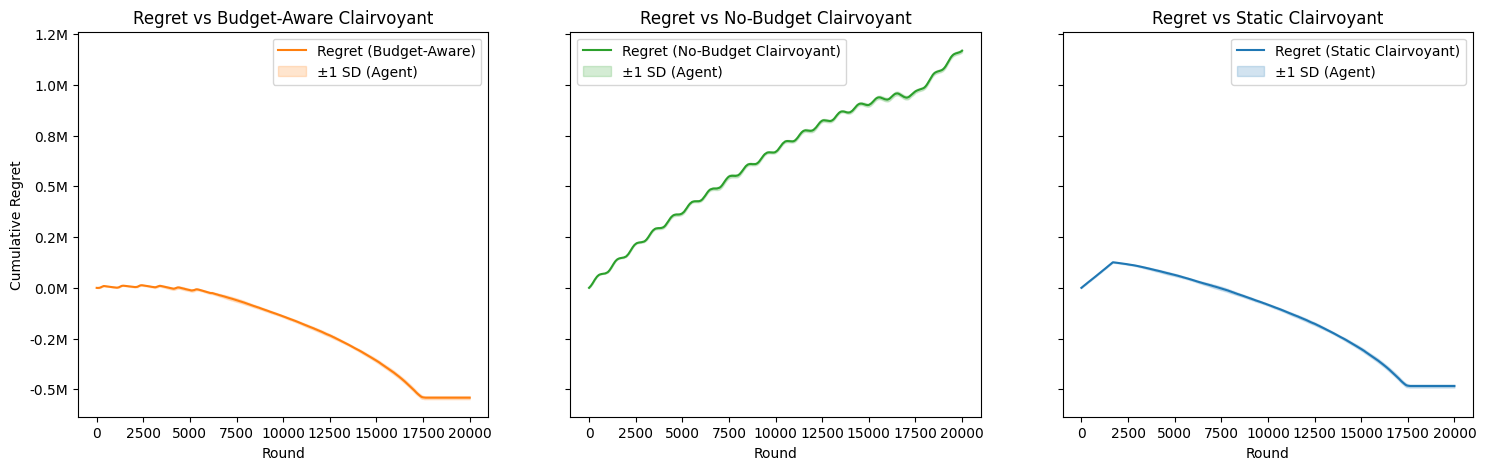

In [15]:
# --- Compute regrets ---
regret_budget_aware = np.array(arm_stats[best_arm]["cum_rewards"]) - mean_cum_util
regret_nobudget = np.array(clairvoyant_nobudget_cum_rewards) - mean_cum_util
regret_static = static_clairvoyant_cum_rewards - mean_cum_util

print(f"Final Regret (Budget-Aware Clairvoyant): {regret_budget_aware[-1]:,.2f}")
print(f"Final Regret (No-Budget Clairvoyant): {regret_nobudget[-1]:,.2f}")
print(f"Final Regret (Static Clairvoyant): {regret_static[-1]:,.2f}")

# --- Plot grid ---
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# --- Budget-Aware Clairvoyant ---
axs[0].plot(regret_budget_aware, color="tab:orange", label="Regret (Budget-Aware)")
axs[0].fill_between(np.arange(T), regret_budget_aware - std_cum_util, regret_budget_aware + std_cum_util, color="tab:orange", alpha=0.2, label="±1 SD (Agent)")
axs[0].set_title("Regret vs Budget-Aware Clairvoyant")
axs[0].set_xlabel("Round")
axs[0].set_ylabel("Cumulative Regret")
axs[0].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions_formatter))
axs[0].legend()

# --- No-Budget Clairvoyant ---
axs[1].plot(regret_nobudget, color="tab:green", label="Regret (No-Budget Clairvoyant)")
axs[1].fill_between(np.arange(T), regret_nobudget - std_cum_util, regret_nobudget + std_cum_util, color="tab:green", alpha=0.2, label="±1 SD (Agent)")
axs[1].set_title("Regret vs No-Budget Clairvoyant")
axs[1].set_xlabel("Round")
axs[1].legend()

# --- Static Clairvoyant ---
axs[2].plot(regret_static, color="tab:blue", label="Regret (Static Clairvoyant)")
axs[2].fill_between(np.arange(T), regret_static - std_cum_util, regret_static + std_cum_util, color="tab:blue", alpha=0.2, label="±1 SD (Agent)")
axs[2].set_title("Regret vs Static Clairvoyant")
axs[2].set_xlabel("Round")
_ = axs[2].legend()

### Plot λ (Lambda) over time

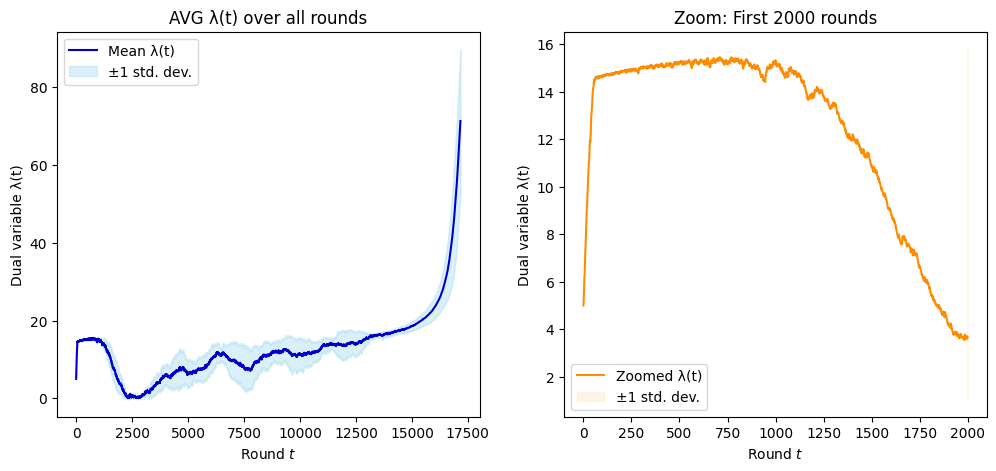

In [16]:
# How important was our constraint during the rounds?
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(np.arange(len(mean_lambda)), mean_lambda, label='Mean λ(t)', color='mediumblue')
plt.fill_between(np.arange(len(mean_lambda)), mean_lambda - std_lambda, mean_lambda + std_lambda, color='skyblue', alpha=0.3, label='±1 std. dev.')
plt.xlabel('Round $t$')
plt.ylabel('Dual variable λ(t)')
plt.title('AVG λ(t) over all rounds')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(mean_lambda))[:zoom_end], mean_lambda[:zoom_end], label='Zoomed λ(t)', color='darkorange')
plt.fill_between(np.arange(len(mean_lambda))[zoom_end], mean_lambda[:zoom_end] - std_lambda[:zoom_end], mean_lambda[:zoom_end] + std_lambda[:zoom_end], color='navajowhite', alpha=0.3, label='±1 std. dev.')
plt.xlabel('Round $t$')
plt.ylabel('Dual variable λ(t)')
plt.title(f'Zoom: First {zoom_end} rounds')
_ = plt.legend()

### Plotting ρ (rho) vs Cost per round

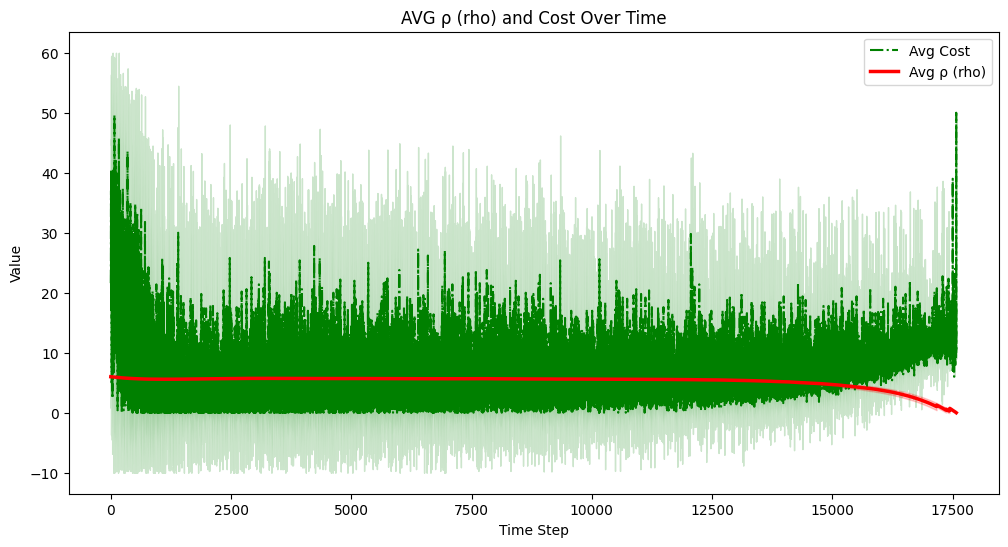

In [17]:
max_len = max(len(r) for r in all_rho)  # max length among trials
all_rho_padded = [r + [np.nan]*(max_len - len(r)) for r in all_rho]
all_sold_pieces_padded = [s + [np.nan]*(max_len - len(s)) for s in all_sold_pieces]

all_rho_array = np.array(all_rho_padded)           
all_sold_pieces_array = np.array(all_sold_pieces_padded)

mean_rho = np.nanmean(all_rho_array, axis=0)
std_rho = np.nanstd(all_rho_array, axis=0)
mean_sold_pieces = np.nanmean(all_sold_pieces_array, axis=0)
std_sold_pieces = np.nanstd(all_sold_pieces_array, axis=0)

time_steps = np.arange(max_len)  # use max_len here!

plt.figure(figsize=(12, 6))

plt.plot(time_steps, mean_sold_pieces, label='Avg Cost', color='green', linestyle='-.')
plt.fill_between(time_steps, mean_sold_pieces - std_sold_pieces, mean_sold_pieces + std_sold_pieces, color='green', alpha=0.2)

plt.plot(time_steps, mean_rho, label='Avg ρ (rho)', color='red', linewidth=2.5, zorder=3)
plt.fill_between(time_steps, mean_rho - std_rho, mean_rho + std_rho, color='red', alpha=0.2)

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('AVG ρ (rho) and Cost Over Time')
_ = plt.legend()